In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            roc_auc_score, roc_curve, auc, precision_recall_curve,
                            confusion_matrix)

from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

#import shap

pd.set_option('display.max_rows', 250)

In [130]:
data = pd.read_csv("F:\TMLC\Patient Survival\Patient Survival Detection\Dataset.csv")
data

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.730000,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.420000,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.950000,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.640000,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,91592,78108,30,0,75.0,23.060250,0,Caucasian,M,177.8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular
91709,66119,13486,121,0,56.0,47.179671,0,Caucasian,F,183.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
91710,8981,58179,195,0,48.0,27.236914,0,Caucasian,M,170.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
91711,33776,120598,66,0,NaN,23.297481,0,Caucasian,F,154.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


# EDA

In [131]:
data.shape

(91713, 186)

In [132]:
data.info(verbose =True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 186 columns):
 #    Column                         Non-Null Count  Dtype  
---   ------                         --------------  -----  
 0    encounter_id                   91713 non-null  int64  
 1    patient_id                     91713 non-null  int64  
 2    hospital_id                    91713 non-null  int64  
 3    hospital_death                 91713 non-null  int64  
 4    age                            87485 non-null  float64
 5    bmi                            88284 non-null  float64
 6    elective_surgery               91713 non-null  int64  
 7    ethnicity                      90318 non-null  object 
 8    gender                         91688 non-null  object 
 9    height                         90379 non-null  float64
 10   hospital_admit_source          70304 non-null  object 
 11   icu_admit_source               91601 non-null  object 
 12   icu_id                        

In [133]:
data.describe()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,91713.000000,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,90379.000000,91713.000000,91713.000000,...,83766.000000,83766.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000
mean,65606.079280,65537.131464,105.669262,0.086302,62.309516,29.185818,0.183736,169.641588,508.357692,0.835766,...,0.086787,0.043955,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638
std,37795.088538,37811.252183,62.854406,0.280811,16.775119,8.275142,0.387271,10.795378,228.989661,2.487756,...,0.247569,0.217341,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169
min,1.000000,1.000000,2.000000,0.000000,16.000000,14.844926,0.000000,137.200000,82.000000,-24.947222,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32852.000000,32830.000000,47.000000,0.000000,52.000000,23.641975,0.000000,162.500000,369.000000,0.035417,...,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65665.000000,65413.000000,109.000000,0.000000,65.000000,27.654655,0.000000,170.100000,504.000000,0.138889,...,0.050000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,98342.000000,98298.000000,161.000000,0.000000,75.000000,32.930206,0.000000,177.800000,679.000000,0.409028,...,0.130000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,131051.000000,131051.000000,204.000000,1.000000,89.000000,67.814990,1.000000,195.590000,927.000000,159.090972,...,0.990000,0.970000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Missing Values


In [134]:
data.isnull().sum().sort_values(ascending=False)

h1_bilirubin_min                 84619
h1_bilirubin_max                 84619
h1_lactate_max                   84369
h1_lactate_min                   84369
h1_albumin_max                   83824
h1_albumin_min                   83824
h1_pao2fio2ratio_min             80195
h1_pao2fio2ratio_max             80195
h1_arterial_ph_max               76424
h1_arterial_ph_min               76424
h1_hco3_max                      76094
h1_hco3_min                      76094
h1_arterial_pco2_min             75959
h1_arterial_pco2_max             75959
h1_wbc_max                       75953
h1_wbc_min                       75953
h1_arterial_po2_max              75945
h1_arterial_po2_min              75945
h1_calcium_max                   75863
h1_calcium_min                   75863
h1_platelets_max                 75673
h1_platelets_min                 75673
h1_bun_max                       75091
h1_bun_min                       75091
h1_creatinine_max                74957
h1_creatinine_min        

Columns to be dropped: **'encounter_id', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'patient_id', 'hospital_id', 'readmission_status'**

We decide a threshold value to delete some of the attributes from the dataset (25k in this approach)  
**74** columns will get deleted in this turn.

In [135]:
large_missing = data.isnull().sum(axis=0).sort_values(ascending=False)[raw_data.isnull().sum(axis=0).sort_values(ascending=False) > 25000]

print("\nTotal features with more than", 25000, "missing values:", len(large_missing))

data.drop(large_missing.index.tolist() + ['encounter_id', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'patient_id', 'hospital_id', 'readmission_status'], 
              axis=1,
             inplace = True)
data


Total features with more than 25000 missing values: 74


,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,icu_type,pre_icu_los_days,weight,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,0,68.0,22.730000,0,Caucasian,M,180.3,CTICU,0.541667,73.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,0,77.0,27.420000,0,Caucasian,F,160.0,Med-Surg ICU,0.927778,70.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,0,25.0,31.950000,0,Caucasian,F,172.7,Med-Surg ICU,0.000694,95.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,0,81.0,22.640000,1,Caucasian,F,165.1,CTICU,0.000694,61.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,0,19.0,NaN,0,Caucasian,M,188.0,Med-Surg ICU,0.073611,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,0,75.0,23.060250,0,Caucasian,M,177.8,Cardiac ICU,0.298611,72.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular
91709,0,56.0,47.179671,0,Caucasian,F,183.0,Med-Surg ICU,0.120139,158.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
91710,0,48.0,27.236914,0,Caucasian,M,170.2,Med-Surg ICU,0.046528,78.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
91711,0,NaN,23.297481,0,Caucasian,F,154.9,Med-Surg ICU,0.081944,55.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


In [136]:
data.nunique()

hospital_death                       2
age                                 74
bmi                              34888
elective_surgery                     2
ethnicity                            6
gender                               2
height                             401
icu_type                             8
pre_icu_los_days                  9757
weight                            3409
apache_2_diagnosis                  44
apache_3j_diagnosis                399
apache_post_operative                2
arf_apache                           2
bun_apache                         476
creatinine_apache                 1127
gcs_eyes_apache                      4
gcs_motor_apache                     6
gcs_unable_apache                    2
gcs_verbal_apache                    5
glucose_apache                     565
heart_rate_apache                  149
hematocrit_apache                  353
intubated_apache                     2
map_apache                         161
resprate_apache          

In [137]:
data.isna().sum()[data.columns.isin(['age','bmi','weight'])]

age       4228
bmi       3429
weight    2720
dtype: int64

In [138]:
data_dn = data[["age",'hospital_death','gender']].dropna()
#data_dn.groupby("gender")["hospital_death"].count()
#sns.countplot(data=data_dn, x=, hue='gender')
#plt.show()

In [139]:
data_mdn =data_dn[(data_dn["gender"]=="M") &(data_dn["hospital_death"]==1) ]
data_fdn =data_dn[data_dn['gender']=='F']

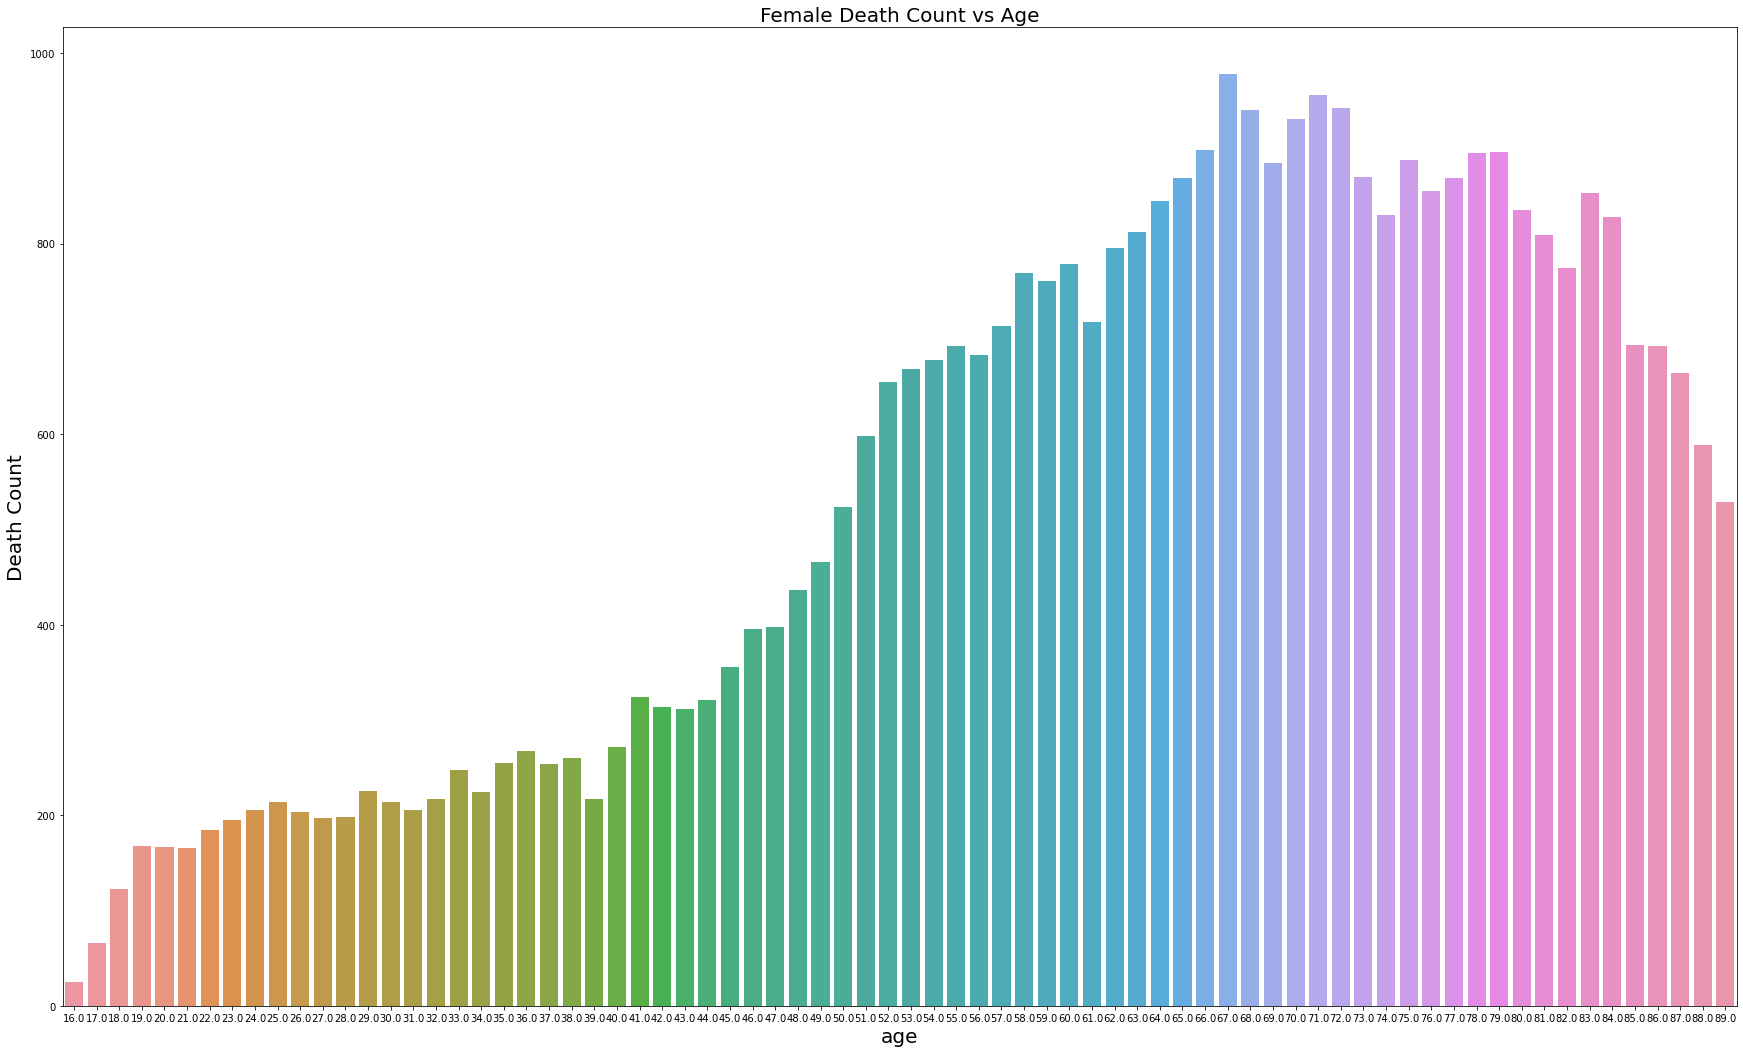

In [140]:
plt.figure(figsize=(30,18))
plt.title("Female Death Count vs Age",fontsize=20)
sns.countplot(data=data_fdn,x="age")
plt.ylabel("Death Count",fontsize=20)
plt.xlabel("age",fontsize=20)
plt.show()

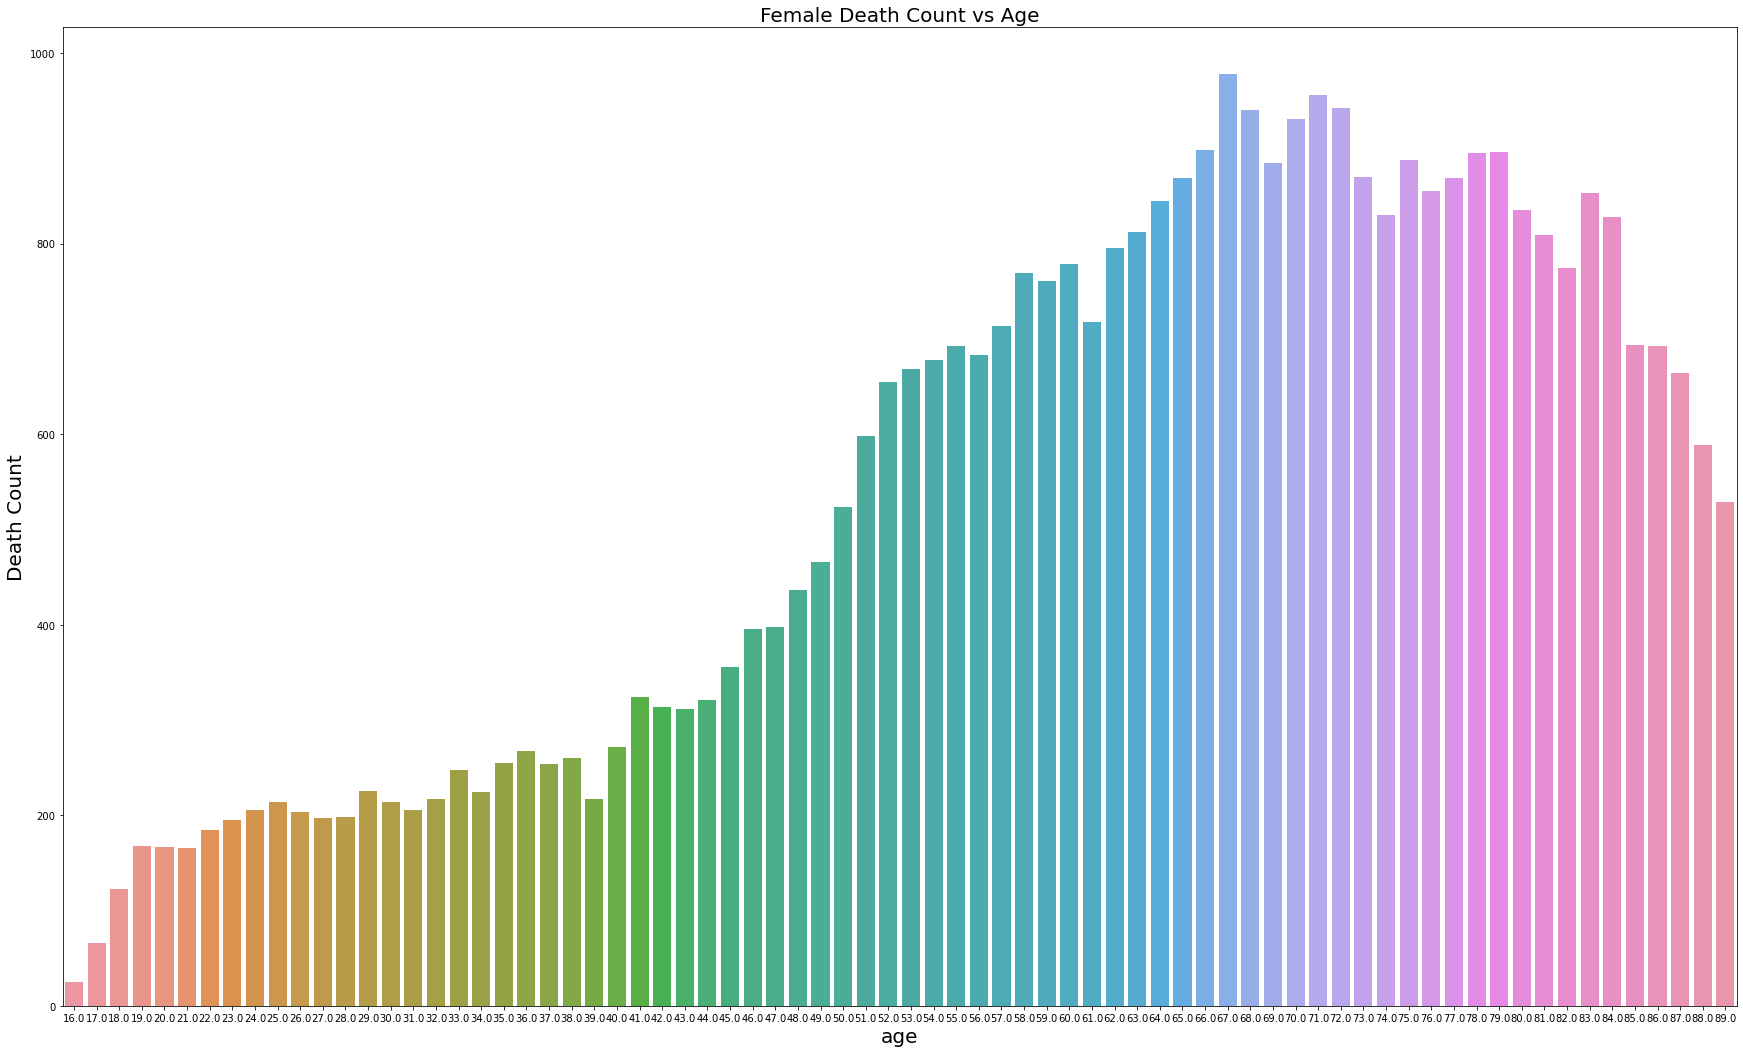

In [141]:
plt.figure(figsize=(30,18))
plt.title("Female Death Count vs Age",fontsize=20)
sns.countplot(data=data_fdn,x="age")
plt.ylabel("Death Count",fontsize=20)
plt.xlabel("age",fontsize=20)
plt.show()

## Average Hospital death based on Gender

In [142]:
age_death_F=data[data['gender']=='F'][['age','hospital_death']].groupby('age').mean().reset_index()
age_death_M=data[data['gender']=='M'][['age','hospital_death']].groupby('age').mean().reset_index()


In [143]:
death_df =data[['age','hospital_death','gender']].groupby(["gender",'age'])['hospital_death'].mean().reset_index()

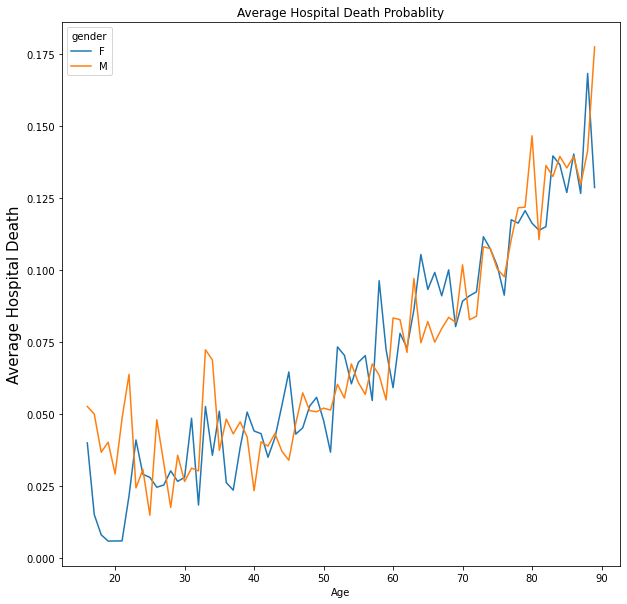

In [144]:
plt.figure(figsize=(10,10))
plt.title('Average Hospital Death Probablity')
plt.xlabel("Age")
plt.ylabel("Average Hospital Death",fontsize=15)
sns.lineplot(data=death_df, x="age", y="hospital_death",hue='gender')
plt.show()

In [145]:
weight_df=data[['weight','hospital_death','bmi']]


In [146]:
weight_death=weight_df[['weight','hospital_death']].groupby('weight').mean().reset_index()
bmi_death=weight_df[['bmi','hospital_death']].groupby('bmi').mean().reset_index()


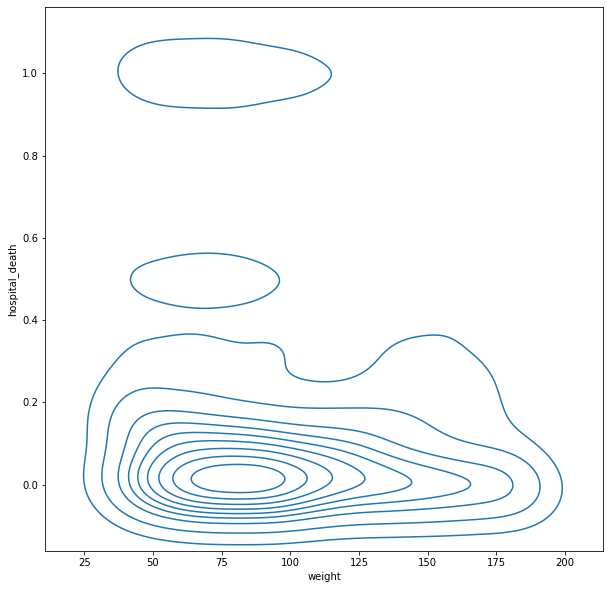

In [147]:
plt.figure(figsize=(10,10))
sns.kdeplot(data=weight_death, x="weight", y="hospital_death")
plt.show()


In [148]:
bmi_death

,bmi,hospital_death
0,14.844926,0.178330
1,14.845267,0.000000
2,14.864195,0.000000
3,14.864540,0.500000
4,14.866950,1.000000
...,...,...
34883,67.779276,0.000000
34884,67.783451,1.000000
34885,67.797806,0.000000
34886,67.812636,0.000000


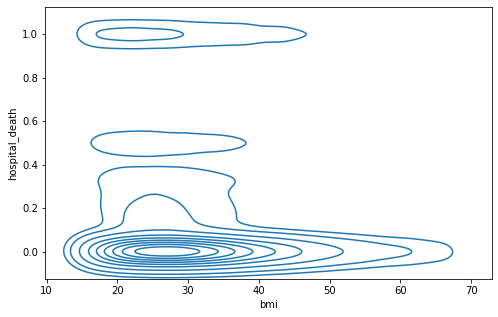

In [149]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=bmi_death, x="bmi", y="hospital_death")
plt.show()


In [150]:
bmi_death

,bmi,hospital_death
0,14.844926,0.178330
1,14.845267,0.000000
2,14.864195,0.000000
3,14.864540,0.500000
4,14.866950,1.000000
...,...,...
34883,67.779276,0.000000
34884,67.783451,1.000000
34885,67.797806,0.000000
34886,67.812636,0.000000


**<span style ="color:maroon"> Hospital Death Rate, by age and Medical condition</span>**

In [153]:
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff


In [158]:
apache3=data[['age','apache_3j_bodysystem','hospital_death']]
apache3=apache3.groupby(['apache_3j_bodysystem','age']).agg(['size','mean']).reset_index()

apache3['size']=apache3['hospital_death']['size']
apache3['mean']=apache3['hospital_death']['mean']

apache3.drop('hospital_death',axis=1,inplace=True)

systems =list(apache3['apache_3j_bodysystem'].unique())
data1 = []
list_updatemenus = []
for n, s in enumerate(systems):
    visible = [False] * len(systems)
    visible[n] = True
    temp_dict = dict(label = str(s),
                 method = 'update',
                 args = [{'visible': visible},
                         {'title': '<b>'+s+'<b>'}])
    list_updatemenus.append(temp_dict)
    

for s in systems:
    mask = (apache3['apache_3j_bodysystem'].values == s) 
    trace = (dict(visible = False,     
        x = apache3.loc[mask, 'age'],
        y = apache3.loc[mask, 'mean'],
        mode = 'markers',
        marker = {'size':apache3.loc[mask, 'size']/apache3.loc[mask,'size'].sum()*1000,
                 'color':apache3.loc[mask, 'mean'],
                 'showscale': True})
                   )
    data1.append(trace)

data1[0]['visible'] = True    
    
layout = dict(updatemenus=list([dict(buttons= list_updatemenus)]),
              xaxis=dict(title = '<b>Age<b>', range=[min(apache3.loc[:, 'age'])-10, max(apache3.loc[:, 'age']) + 10]),
              yaxis=dict(title = '<b>Average Hospital Death<b>', range=[min(apache3.loc[:, 'mean'])-0.1, max(apache3.loc[:, 'mean'])+0.1]),
              title='<b>Survival Rate<b>' )
fig = dict(data=data1, layout=layout)
py.iplot(fig, filename='update_dropdown')

In [155]:
data[['age','apache_3j_bodysystem','hospital_death']]

,age,apache_3j_bodysystem,hospital_death
0,68.0,Sepsis,0
1,77.0,Respiratory,0
2,25.0,Metabolic,0
3,81.0,Cardiovascular,0
4,19.0,Trauma,0
...,...,...,...
91708,75.0,Sepsis,0
91709,56.0,Sepsis,0
91710,48.0,Metabolic,0
91711,NaN,Respiratory,0


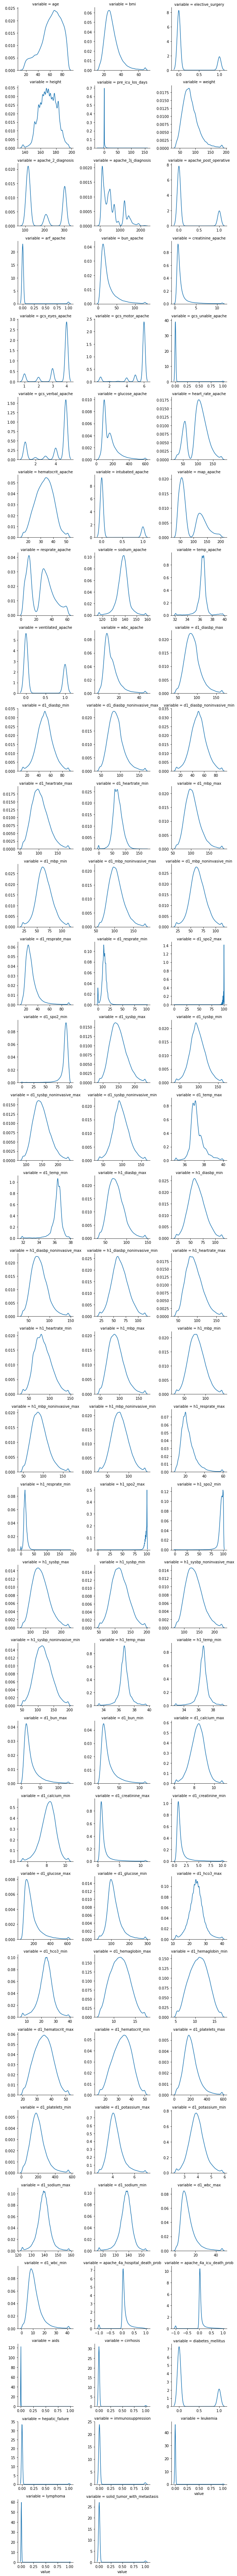

In [156]:
unpivot = pd.melt(data,data.describe().columns[0], data.describe().columns[1:])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot, "value")

plt.show()

## Preprocessing
converting categorical values
tranforming numerical columns and removing nulls

Null values for categories are replaced by mode, and those for numerical are replaced by mean

In [182]:
data = data[data[['bmi', 'weight', 'height']].isna().sum(axis=1) == 0]
data

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,icu_type,pre_icu_los_days,weight,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,0,68.0,22.730000,0,Caucasian,M,180.3,CTICU,0.541667,73.9,...,0,0,1,0,0,0,0,0,Sepsis,Cardiovascular
1,0,77.0,27.420000,0,Caucasian,F,160.0,Med-Surg ICU,0.927778,70.2,...,0,0,1,0,0,0,0,0,Respiratory,Respiratory
2,0,25.0,31.950000,0,Caucasian,F,172.7,Med-Surg ICU,0.000694,95.3,...,0,0,0,0,0,0,0,0,Metabolic,Metabolic
3,0,81.0,22.640000,1,Caucasian,F,165.1,CTICU,0.000694,61.7,...,0,0,0,0,0,0,0,0,Cardiovascular,Cardiovascular
5,0,67.0,27.560000,0,Caucasian,M,190.5,Med-Surg ICU,0.000694,100.0,...,0,0,1,0,0,0,0,0,Neurological,Neurologic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,0,75.0,23.060250,0,Caucasian,M,177.8,Cardiac ICU,0.298611,72.9,...,0,0,1,0,0,0,0,1,Sepsis,Cardiovascular
91709,0,56.0,47.179671,0,Caucasian,F,183.0,Med-Surg ICU,0.120139,158.0,...,0,0,0,0,0,0,0,0,Sepsis,Cardiovascular
91710,0,48.0,27.236914,0,Caucasian,M,170.2,Med-Surg ICU,0.046528,78.9,...,0,0,1,0,0,0,0,0,Metabolic,Metabolic
91711,0,NaN,23.297481,0,Caucasian,F,154.9,Med-Surg ICU,0.081944,55.9,...,0,0,0,0,0,0,0,0,Respiratory,Respiratory


In [183]:
numerical_cat = [
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

In [184]:
categorical = ['ethnicity',
 'gender',
 'icu_type',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']

In [185]:
data.nunique()[raw_data.nunique() == 2].index.tolist()

['hospital_death',
 'elective_surgery',
 'gender',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

In [186]:
data.select_dtypes(include='O').columns.values.tolist()

['ethnicity',
 'gender',
 'icu_type',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']

In [187]:
not_numeric = data[numerical_cat + categorical + ['hospital_death']].columns.tolist()
numeric_only = data.drop(not_numeric,axis=1).columns.tolist()
numeric_only

['age',
 'bmi',
 'height',
 'pre_icu_los_days',
 'weight',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'bun_apache',
 'creatinine_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_verbal_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'map_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'wbc_apache',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',
 'd1_temp_max',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_diasbp_noninvasive_max',
 'h1_diasbp_noninvasive_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'h1_mbp_noninvasive_max',
 'h1_mbp_noninvasive_min',
 'h1_re

In [188]:
for col in numerical_cat:
    data[col] = raw_data[col].astype('Int64')
    
for col in numerical_cat:
    data[col] = raw_data[col].fillna(raw_data[col].mode()[0])

In [189]:
data[numeric_only].isna().sum(axis=0).sort_values(ascending=False)

wbc_apache                       21063
h1_temp_max                      20833
h1_temp_min                      20833
hematocrit_apache                19005
bun_apache                       18289
creatinine_apache                17926
sodium_apache                    17644
d1_hco3_max                      14390
d1_hco3_min                      14390
d1_platelets_min                 12767
d1_platelets_max                 12767
d1_wbc_max                       12501
d1_wbc_min                       12501
d1_calcium_min                   12315
d1_calcium_max                   12315
d1_hemaglobin_max                11519
d1_hemaglobin_min                11519
d1_hematocrit_max                11051
d1_hematocrit_min                11051
glucose_apache                   10473
d1_bun_min                        9860
d1_bun_max                        9860
d1_creatinine_min                 9561
d1_creatinine_max                 9561
d1_sodium_max                     9554
d1_sodium_min            

In [190]:
split_one = data[numeric_only].isna().sum(axis=0).sort_values()[data[numeric_only].isna().sum(axis=0) < 11000].index.tolist()
split_two = data[numeric_only].isna().sum(axis=0).sort_values()[data[numeric_only].isna().sum(axis=0) > 11000].index.tolist()

In [192]:
split_one

['bmi',
 'height',
 'pre_icu_los_days',
 'weight',
 'd1_heartrate_min',
 'd1_heartrate_max',
 'd1_sysbp_min',
 'd1_sysbp_max',
 'd1_diasbp_min',
 'd1_diasbp_max',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_spo2_min',
 'd1_spo2_max',
 'd1_resprate_max',
 'd1_resprate_min',
 'heart_rate_apache',
 'map_apache',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',
 'd1_diasbp_noninvasive_min',
 'd1_diasbp_noninvasive_max',
 'apache_3j_diagnosis',
 'resprate_apache',
 'd1_mbp_noninvasive_min',
 'd1_mbp_noninvasive_max',
 'apache_2_diagnosis',
 'gcs_motor_apache',
 'gcs_verbal_apache',
 'gcs_eyes_apache',
 'd1_temp_min',
 'd1_temp_max',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_sysbp_min',
 'h1_sysbp_max',
 'h1_diasbp_min',
 'h1_diasbp_max',
 'temp_apache',
 'h1_spo2_max',
 'h1_spo2_min',
 'age',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'd1_glucose_min',
 'd1_glucose_max',
 'h1_sysbp_noninvasive_min',
 'h1_sysbp_noninvasive_max',
 'h1_diasbp_noninvasive_max',


In [191]:
split_two

['d1_hematocrit_max',
 'd1_hematocrit_min',
 'd1_hemaglobin_min',
 'd1_hemaglobin_max',
 'd1_calcium_max',
 'd1_calcium_min',
 'd1_wbc_max',
 'd1_wbc_min',
 'd1_platelets_min',
 'd1_platelets_max',
 'd1_hco3_max',
 'd1_hco3_min',
 'sodium_apache',
 'creatinine_apache',
 'bun_apache',
 'hematocrit_apache',
 'h1_temp_min',
 'h1_temp_max',
 'wbc_apache']

In [193]:
for col in split_two:
    data[col] = data[col].fillna(data[col].mean())

process_data = data.dropna(axis=0)

In [194]:
process_data[categorical].nunique()

ethnicity                6
gender                   2
icu_type                 8
apache_3j_bodysystem    11
apache_2_bodysystem     10
dtype: int64

In [195]:
icu_data = pd.get_dummies(process_data,
    prefix='isin',
    prefix_sep='_',
    columns=categorical,
    drop_first=False)
icu_data.reset_index(drop = True, inplace = True)
icu_data

,hospital_death,age,bmi,elective_surgery,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,...,isin_Cardiovascular,isin_Gastrointestinal,isin_Haematologic,isin_Metabolic,isin_Neurologic,isin_Renal/Genitourinary,isin_Respiratory,isin_Trauma,isin_Undefined Diagnoses,isin_Undefined diagnoses
0,0,68.0,22.730000,0,180.3,0.541667,73.9,113.0,502.01,0,...,1,0,0,0,0,0,0,0,0,0
1,0,77.0,27.420000,0,160.0,0.927778,70.2,108.0,203.01,0,...,0,0,0,0,0,0,1,0,0,0
2,0,67.0,27.560000,0,190.5,0.000694,100.0,301.0,403.01,0,...,0,0,0,0,1,0,0,0,0,0
3,0,46.0,25.845717,0,167.6,0.000000,72.6,108.0,203.01,0,...,0,0,0,0,0,0,1,0,0,0
4,0,87.0,21.963763,0,180.3,5.046528,71.4,113.0,501.05,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53108,0,47.0,51.439842,1,195.0,0.033333,186.0,304.0,1406.01,1,...,0,1,0,0,0,0,0,0,0,0
53109,0,54.0,19.770448,0,177.8,0.025694,62.5,109.0,108.01,0,...,1,0,0,0,0,0,0,0,0,0
53110,0,75.0,23.060250,0,177.8,0.298611,72.9,113.0,501.06,0,...,1,0,0,0,0,0,0,0,0,0
53111,0,56.0,47.179671,0,183.0,0.120139,158.0,113.0,501.05,0,...,1,0,0,0,0,0,0,0,0,0


In [196]:
icu_data.columns = [x.lower() for x in icu_data.columns.tolist()]
icu_data = icu_data.loc[:,~icu_data.columns.duplicated()]

## Modelling

In [197]:
X = icu_data.drop(['hospital_death'], axis=1)
y = icu_data['hospital_death']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    random_state=11, 
                                                    stratify = y)

In [198]:
y_train.value_counts()

0    33923
1     3256
Name: hospital_death, dtype: int64

In [199]:
y_test.value_counts()

0    14538
1     1396
Name: hospital_death, dtype: int64

In [200]:
def modelling(X_train, y_train, X_test, y_test, **kwargs):
    scores = {}
    models = []
    if 'xgb' in kwargs.keys() and kwargs['xgb']:
        xgb = XGBClassifier()
        xgb.fit(X_train._get_numeric_data(), np.ravel(y_train, order='C'))
        y_pred = xgb.predict(X_test._get_numeric_data())
        scores['xgb']= [accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred)]
#         scores['xgb']['roc_auc'] = roc_auc_score(y_test, y_pred)

    if 'rf' in kwargs.keys() and kwargs['rf']:
        rf = RandomForestClassifier(n_estimators=200)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        scores['rf']= [accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred)]
#         scores['rf']['roc_auc'] = roc_auc_score(y_test, y_pred)
        models.append(rf)

    if 'extree' in kwargs.keys() and kwargs['extree']:
        extree = ExtraTreesClassifier()
        extree.fit(X_train, y_train)
        y_pred = extree.predict(X_test)
        scores['extree'] = [accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred)]
#         scores['extree']['roc_auc'] = roc_auc_score(y_test, y_pred)
        models.append(extree)
        
    return scores

In [201]:
modelling(X_train,y_train, X_test, y_test, xgb=True, rf=True, extree=True)

{'xgb': [0.9247521024224927, 0.6495594886003719],
 'rf': [0.925756244508598, 0.6161135465163718],
 'extree': [0.9233086481737166, 0.5898416697511629]}

In [202]:
def model_performance(model, y_test, y_hat) : 
    conf_matrix = confusion_matrix(y_test, y_hat)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #Roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_hat) , 3)
    fpr, tpr, t = roc_curve(y_test, y_hat)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
     
    #plots
    model = model
    
    #Subplots
    fig = tls.make_subplots(rows=2, cols=2, print_grid=False, 
                          specs=[ 
#                               [{'colspan': 2}, None],
                                 [{}, {}],
                                 [{}, {}],
                                 
#                                  [{'colspan': 2}, None]
                                ],
                          subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                        'Precision - Recall curve',
                                        ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                        autosize = False, height = 1500,width = 830,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        margin = dict(b = 195))
#     fig["layout"]["xaxis2"].update((dict(range=[0, 1])))
#     fig["layout"]["xaxis3"].update(dict(title = "false positive rate"))
#     fig["layout"]["yaxis3"].update(dict(title = "true positive rate"))
#     fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05])
#     fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05])
#     fig["layout"]["xaxis5"].update(dict(title = "Percentage contacted"))
#     fig["layout"]["yaxis5"].update(dict(title = "Percentage positive targeted"))
    fig.layout.titlefont.size = 14
    
    py.iplot(fig)

## Parameter Tuning

In [204]:
gkf = KFold(n_splits=3, shuffle=True, random_state=42).split(X=X_train, y=y_train)

fit_params_of_xgb = {
    "early_stopping_rounds":100, 
    "eval_metric" : 'auc', 
    "eval_set" : [(X_test, y_test)],
    'verbose': 100,
}


# A parameter grid for XGBoost
params = {
    'booster': ["gbtree"],
    'learning_rate': [0.1],
    'n_estimators': range(100, 500, 100),
    'min_child_weight': [1],
    'gamma': [0],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'max_depth': [5],
    "scale_pos_weight": [1]
}

xgb_estimator = XGBClassifier(
    objective='binary:logistic',
    # silent=True,
)

gsearch = GridSearchCV(
    estimator=xgb_estimator,
    param_grid=params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=gkf
)

xgb_model = gsearch.fit(X=X_train, y=y_train, **fit_params_of_xgb)
(gsearch.best_params_, gsearch.best_score_)

[0]	validation_0-auc:0.85927
[99]	validation_0-auc:0.89420


({'booster': 'gbtree',
  'colsample_bytree': 0.8,
  'gamma': 0,
  'learning_rate': 0.1,
  'max_depth': 5,
  'min_child_weight': 1,
  'n_estimators': 100,
  'scale_pos_weight': 1,
  'subsample': 0.8},
 0.8818956441821438)

# Model Evaluation

In [206]:
xgb_tuned = XGBClassifier(n_estimators=3000,
    objective='binary:logistic',
    booster="gbtree",
    learning_rate=0.01,
    scale_pos_weight=1,
    max_depth=4,
    min_child_weight=6,
    gamma=0,
    subsample=0.4,
    colsample_bytree=0.8,
    reg_alpha=0.08,
    n_jobs=-1)

xgb_tuned.fit(X_train._get_numeric_data(), np.ravel(y_train, order='C'))
y__hat = xgb_tuned.predict(X_test._get_numeric_data())

In [207]:
model_performance(xgb_tuned,y_test, y__hat)